# Weighted Linear Regression


## Learning Objectives

After studying this notebook and your lecture notes, you should be able to:
* Apply weighted linear regression to correct for distortions with transformations

In [15]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Michaelis-Menten Modeling Revisited

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

$$
r = V_{max} \frac{[\mathbf{S}]}{K_M + [\mathbf{S}]}
$$

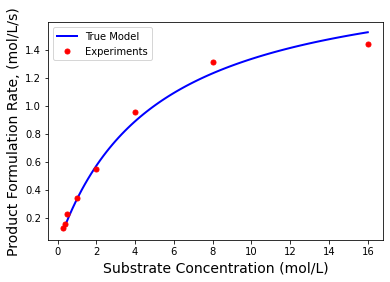

In [16]:
## Let's plot the model

# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

plt.plot(S,r,'b-',linewidth=2,label="True Model")
plt.plot(Sexp,rexp,'r.',markersize=10,label="Experiments")
plt.xlabel('Substrate Concentration (mol/L)',fontsize=14)
plt.ylabel('Product Formulation Rate, (mol/L/s)',fontsize=14)
plt.legend()
plt.show()

## Main Idea

Weight data points with greater uncertainty less.

$$
\min_{\hat{\beta}} \quad (y - X \hat{\beta})^T ~W~ (y - X \hat{\beta})
$$

What to use for the weight matrix $W$?

Let's assume each $r_{obs}$ measurement (i.e., observation) has uncertainty $\epsilon$:

$r_{obs} = r_{true} + \epsilon$

where var($\epsilon$) = $\sigma^2$. What is the uncertainty in $1/r_{obs}$?

**Short Activity**: Determine var($1/r_{obs}$) with a partner.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, compute var($1/r_{obs}$). Assume $\epsilon$ is a random variable.
</div>

## Step 1: Calculate Best Fit and Plot

Let's further assume each observation uncertainty is independent. We will weight the regression problem with matrix $W$, which is proportional to the inverse of the covariance matrix:

$$
W = \begin{bmatrix}r_{1}^4 & 0 & \dots & 0 \\
0 & r_{2}^4 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & r_{n}^4
\end{bmatrix}
$$

The solution to the optimization problem above is easily calculated with linear algebra:

$$
(X^T W X) \hat{\beta} = X^T W y
$$

or

$$
\hat{\beta} = (X^T W X)^{-1} X^T W y
$$

Some textbooks define $K = (X^T W X)^{-1}$ to simplify the above expressions. Let's apply this to our problem.

In [23]:
# diagonal elements
print(rexp**4)

[2.66364503e-04 5.58880502e-04 2.80850463e-03 1.30330270e-02
 9.15301482e-02 8.25854937e-01 2.98981155e+00 4.30818556e+00]


In [24]:
# create a diagonal matrix
W = np.diag(rexp**4)
print("W =\n",W)

W =
 [[2.66364503e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.58880502e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.80850463e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.30330270e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.15301482e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.25854937e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.98981155e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30818556e

In [25]:
# recall the transformation
y = 1/rexp
x = 1/Sexp

# construct the feature matrix
n = len(x)
Xmm = np.ones((n,2))

# first column - all ones
# second column - 1/r
Xmm[:,1] = x

# calculate inverse of XT * X
XXinv = np.linalg.inv(Xmm.transpose() @ W @ Xmm)
print("K = inv(XT W X) =\n",XXinv)

K = inv(XT W X) =
 [[ 0.30688101 -1.66594579]
 [-1.66594579 14.96929305]]


In [26]:
# calculate beta_hat
beta_hat_w = XXinv @ Xmm.transpose() @ W @ y

print("beta_hat_w = \n",beta_hat_w)

beta_hat_w = 
 [0.53380361 2.13825004]


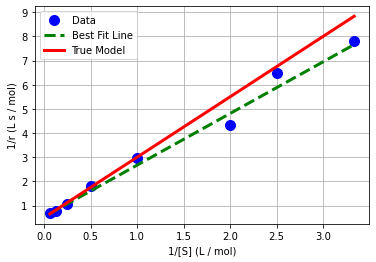

In [27]:
# generate predictions
x_pred = np.linspace(np.min(x),np.max(x),1000)
X_pred = np.ones((len(x_pred),2))
X_pred[:,1] = x_pred
y_pred = X_pred @ beta_hat_w

# create plot
plt.plot(x,y,'.b',markersize=20,label='Data')
plt.plot(x_pred,y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(1/S,1/r,'r-',linewidth=3,label='True Model')
plt.xlabel('1/[S] (L / mol)')
plt.ylabel('1/r (L s / mol)')
plt.grid(True)
plt.legend()
plt.show()

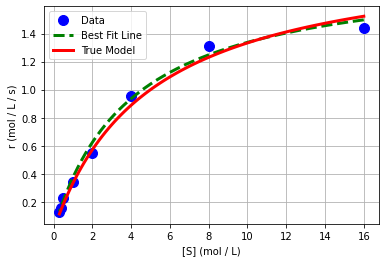

In [28]:
# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(1/x_pred,1/y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

## Step 2. Residual Analysis

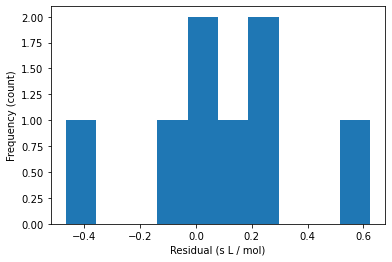

In [29]:
# Calculate residuals
y_hat = Xmm @ beta_hat_w
e = y - y_hat

# plot histogram of residuals
plt.hist(e)
plt.xlabel("Residual (s L / mol)")
plt.ylabel("Frequency (count)")
plt.show()

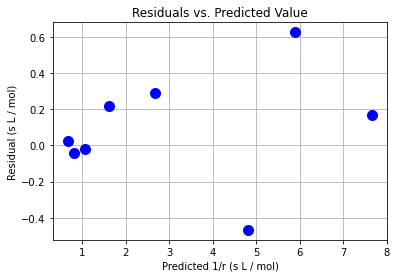

In [30]:
# scatter plot of residuals
plt.plot(y_hat,e,"b.",markersize=20)
plt.xlabel("Predicted 1/r (s L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

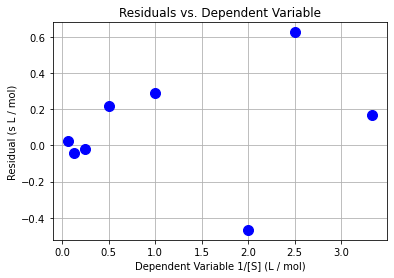

In [31]:
# another scatter plot
plt.plot(x,e,"b.",markersize=20)
plt.xlabel("Dependent Variable 1/[S] (L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

## Uncertainty Analysis

We also need to incorporate the weight matrix into our uncertainty analysis:

$$
\Sigma_{\beta} = K X^T W \Sigma_{e} W^T X K
$$

where $\Sigma_{e}$ is the covariance matrix of the residuals. We often assume $\Sigma_{e} = \hat{\sigma}_{e}^2 I$ where $I$ is an identity matrix.

In [32]:
# calculate variance of residuals
sigre = e @ e / (n-2)
print("Variance of residuals =",sigre)

Variance of residuals = 0.1278012187330729


In [34]:
# calculate covariance of fitted coefficients
cov_beta = XXinv @ Xmm.transpose() * sigre @ W.transpose() @ Xmm @ XXinv
print("covariance matrix:\n",cov_beta)

covariance matrix:
 [[ 0.03921977 -0.2129099 ]
 [-0.2129099   1.9130939 ]]


## Other Approaches

An second approach is to use [Transformation + Linear Regression.](../15/Transformations-and-Linear-Regression.ipynb)  This is method fits a linear model to the data without weighting the variables differently.

A third approach is to use [Nonlinear Regression.](../15/Nonlinear-Regression.ipynb)  Nonlinear regression fits a curve to the data rather than a line, so this may be better in some instances depending on the data.


However, the weighted regression from this notebook is often useful as it gives different weight to the various variables to help correct for inconcsistencies and distortions in the data that the other two methods cannot account for.